# Pruning defense

Prune an EfficientNetv2 model that has been pretrained on the CIFAR-10 dataset.

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [3]:
from Data import Data

In [4]:
DATASETS_DIR = os.path.join("..", "datasets")
CIFAR_DIR = os.path.join(DATASETS_DIR, "CIFAR10", "cifar-10")

MODEL_NAME = 'efficientnet_v2_s'
WEIGHT_PATH = os.path.join("..", "models", "efficientnet_v2_s_cifar10.pth")

## Load locally stored CIFAR-10

We'll just be using the clean dataset for now.

In [5]:
train_images = os.path.join(CIFAR_DIR, "train", "data.npy")
train_labels = os.path.join(CIFAR_DIR, "train", "labels.npy")
test_images = os.path.join(CIFAR_DIR, "test", "data.npy")
test_labels = os.path.join(CIFAR_DIR, "test", "labels.npy")

cifar_10_dataset= Data(train_images=train_images,train_labels=train_labels,
                     test_images=test_images,test_labels=test_labels)

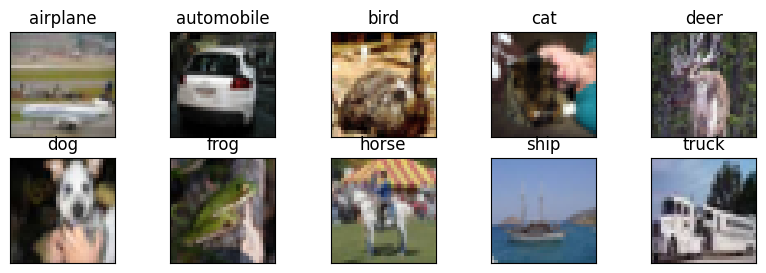

In [6]:
# cifar_10_dataset.normalize()
cifar_10_dataset.show_images()

## Load the pretrained weights

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', MODEL_NAME, nclass=cifar_10_dataset.num_classes, skip_validation=False)
model.to(device)

state_dict = torch.load(WEIGHT_PATH)
model.load_state_dict(state_dict)

device

Using cache found in C:\Users\Marko Haralović/.cache\torch\hub\hankyul2_EfficientNetV2-pytorch_main


device(type='cpu')

## Visualize activations of ~~the last convolutional layer~~ any layer

> "Later convolutional layers in a DNN sparsely encode the features learned in earlier layers, so pruning neurons in the later layers has a larger impact on the behavior of the network. Consequently, **we prune only the last convolutional layer**..."


In [8]:
# Available layers
list(model.state_dict().keys())

['stem.0.weight',
 'stem.1.weight',
 'stem.1.bias',
 'stem.1.running_mean',
 'stem.1.running_var',
 'stem.1.num_batches_tracked',
 'blocks.0.block.fused.0.weight',
 'blocks.0.block.fused.1.weight',
 'blocks.0.block.fused.1.bias',
 'blocks.0.block.fused.1.running_mean',
 'blocks.0.block.fused.1.running_var',
 'blocks.0.block.fused.1.num_batches_tracked',
 'blocks.1.block.fused.0.weight',
 'blocks.1.block.fused.1.weight',
 'blocks.1.block.fused.1.bias',
 'blocks.1.block.fused.1.running_mean',
 'blocks.1.block.fused.1.running_var',
 'blocks.1.block.fused.1.num_batches_tracked',
 'blocks.2.block.fused.0.weight',
 'blocks.2.block.fused.1.weight',
 'blocks.2.block.fused.1.bias',
 'blocks.2.block.fused.1.running_mean',
 'blocks.2.block.fused.1.running_var',
 'blocks.2.block.fused.1.num_batches_tracked',
 'blocks.2.block.fused_point_wise.0.weight',
 'blocks.2.block.fused_point_wise.1.weight',
 'blocks.2.block.fused_point_wise.1.bias',
 'blocks.2.block.fused_point_wise.1.running_mean',
 'blocks

In [9]:
SELECTED_WEIGHT_KEY = 'blocks.0.block.fused.0.weight'

In [10]:
layer_weights = model.state_dict()[SELECTED_WEIGHT_KEY]

layer_weights.size()

torch.Size([24, 24, 3, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


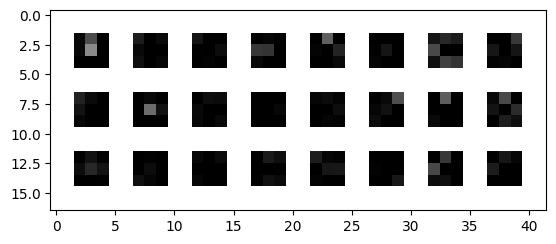

In [11]:
# Only visualize the first out of 24 channels

grid = make_grid(layer_weights[:,:1,:,:], pad_value=1)
np_grid = grid.cpu().numpy()
plt.imshow(np.transpose(np_grid, (1, 2, 0)))
plt.show()

# ...

In [12]:
print(model)

EfficientNetV2(
  (stem): ConvBNAct(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (blocks): Sequential(
    (0): MBConv(
      (block): Sequential(
        (fused): ConvBNAct(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (stochastic_path): StochasticDepth()
    )
    (1): MBConv(
      (block): Sequential(
        (fused): ConvBNAct(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (stochastic_path): StochasticDepth()
    )
    (2): MBConv(
      (block): Sequential(
  

# Test model on test dataset (measure accuracy) for comparison after pruning 

In [13]:
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset

In [14]:
cifar_10_dataset.normalize()

In [15]:
test_data = torch.tensor(cifar_10_dataset.test_images, dtype=torch.float32).permute(0, 3, 1, 2)
test_labels = torch.tensor(cifar_10_dataset.test_labels, dtype=torch.long)
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
def evaluate_model(model, data_loader, device):
    model.eval()  
    total = 0
    correct = 0
    i = 0
    resize_transform = transforms.Resize((224, 224), antialias=True)

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            # Resize images here if facing memory issues with whole dataset reshaped at once
            images = torch.stack([resize_transform(img) for img in images])
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            i = i + 1

    accuracy = 100 * correct / total
    return accuracy

In [17]:
accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {accuracy}%')


NameError: name 'transforms' is not defined

## Prune last convolutional layer in Efficient Net and evaluate new model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
prune_rate = 0.2

In [ ]:
train_data = torch.tensor(cifar_10_dataset.train_images, dtype=torch.float32).permute(0, 3, 1, 2)
train_labels = torch.tensor(cifar_10_dataset.train_labels, dtype=torch.long)
train_dataset = TensorDataset(train_data, train_labels)


In [ ]:
tr_loader = DataLoader(train_dataset, batch_size=64,
                               num_workers=8 ,
                               drop_last=True, pin_memory=True)

In [ ]:
layer_to_prune = None
for name, module in model.named_modules():
    if name == 'blocks.39.block.depth_wise.0':
        layer_to_prune = module
        break

if layer_to_prune is not None:
    hook = layer_to_prune.register_forward_hook(forward_hook)
else:
    raise AttributeError("Layer 'blocks.39.block.depth_wise.0' not found in the model")


print(layer_to_prune)

Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)


In [ ]:
print("======== pruning... ========")
with torch.no_grad():
   container = []
   def forward_hook(module, input, output):
      container.append(output)
   #hook = getattr(model, layer_to_prune).register_forward_hook(forward_hook)
   hook = layer_to_prune.register_forward_hook(forward_hook)
   print("Forwarding all training set")
   model.eval()
   for data, _ in tr_loader:
      if device =="cuda":
         model(data.cuda())
      else:
         model(data)
      hook.remove()

======== pruning... ========
Forwarding all training set


In [ ]:
hook.remove()
print(container)

In [ ]:
squeezed_outputs = [torch.squeeze(output) for output in container]
container =  torch.cat(squeezed_outputs, dim=0)


In [ ]:
# activation = torch.mean(container, dim=[0, 2, 3])
activation = torch.mean(container)
seq_sort = torch.argsort(activation)
num_channels = len(activation)
prunned_channels = int(num_channels * prune_rate)
mask = torch.ones(num_channels).to(device)

In [ ]:
for element in seq_sort[:prunned_channels]:
   mask[element] = 0
if len(container.shape) == 4:
   mask = mask.reshape(1, -1, 1, 1)

In [ ]:
#hook = getattr(model, layer_to_prune).register_forward_hook(forward_hook)
# hook = layer_to_prune.register_forward_hook(forward_hook)

In [ ]:
setattr(model, layer_to_prune, MaskedLayer(layer_to_prune, mask))
model = model
print("======== pruning complete ========")

In [ ]:
accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {accuracy}%')
